# **CAL FIRE Trend Forecasting and Analysis**


## Description and deliverables

California experiences some of the most severe and frequent wildfires in the United States. With the current tides of climate change, population growth, and developing land uses, understanding patterns of wildfire activity is becoming an increasingly important consideration for the residents and government of California. To better understand these patterns and support proactive decision-making, this project focuses on trend forecasting and analysis using historical incident data provided by CAL Fire.

The project integrates data analytics and machine learning techniques to explore wildfire behavior, identify risk factors, and generate predictive insights. The workflow begins with acquiring raw incident data directly from CAL FIRE's public databases, followed by data cleaning, transformation, and storage in a relation database for efficient querying. Exploratory data analysis (EDA) highlights temporal, geographic, and environmental patterns to allow for further insights. Additionally, machine learning techniques are applied to the data in order to uncover even more trends that display wildfire activity analytics.

The end product is a data pipeline and interactive dashboard that automatically updates with new incident data, delivering actionable insights to fire management agencies, policymakers, and researchers. This allows stakeholders to track wildfire activity in realtime, monitor trends, and simulate future scenarios to improve preparedness, resource allocation, and public safety.

This notebook serves as the back-bone of this project's workflow. While all dashboards, visualizations, and metrics can be viewed by running the the core Python file, this notebook keeps track of the ins-and-outs of the decision-making behind the analysis.

## Exploratory Data Analysis (EDA)

In the dataset provided by [CAL FIRE](https://www.fire.ca.gov/), detailed records of wildfire incidents across California are made publicly available. The data can be accessed directly through CAL FIRE's open data portal [here](https://incidents.fire.ca.gov/imapdata/mapdataall.csv), which is updated regularly to reflect both active and historical incidents.

This dataset includes a number of attributes, but the ones we will be focusing on are:
Variable|Description |
-----|-----|
incident_name | The official name or title of the wildfire incident.|
incident_date_created | The date and time when the incident was first reported or created in the system.|
incident_administrative_unit | The CAL FIRE administrative unit or agency responsible for managing the incident.|
incident_county | The county in California where the incident occurred.|
incident_location | A descriptive location of the incident, such as city, town, or nearby landmark.|
incident_acres_burned | The total number of acres burned during the incident.|
incident_containment | The percentage of the fire that has been contained at the time of reporting.|
incident_cooperating_agencies | Other local, state, or federal agencies assisting with the incident response.|
incident_longitude | The longitude coordinate of the incident’s location.|
incident_latitude | The latitude coordinate of the incident’s location.|
incident_id | A unique identifier assigned to each incident (string or numeric).|
incident_url | A direct link to the CAL FIRE incident webpage for more details.|
incident_date_extinguished | The date and time when the incident was declared fully extinguished.|
is_active | Status flag indicating whether the incident is still active or has been contained/closed. |
calfire_incident | Boolean value indicating whether the incident was directly managed by CAL FIRE. |

## Step 1. Initializing a Database

The first step in our analysis is to construct a database to store the most up-to-date 'incidents' data. For this task, we will be initializing a Google Cloud PostgreSQL instance and creating/uploading/verifying our database automatically when the username and password are entered. The included Python script in this repository, "download_data.py", will complete this when run in the next code block if execute is set to "True" (Only enable if database is online). After, all we have to do is query the data and begin EDA!

In [15]:
# Execute the creation of Database
create = False
# Set to true if PostgreSQL database is online
accessible = True
instance_connection_name = 'instance_name:us-west1:wildfires-postgres'
db_user = 'postgres'
db_pass = 'password'

In [16]:
if create:
    try:
        import push_to_PostgreSQL
        push_to_PostgreSQL.main(instance_connection_name, db_user, db_pass)
        print("Database created successfully")
    except Exception as e:
        print(f"Database creation failed: {e}")
if accessible:
    import extract_from_PostgreSQL
    df = extract_from_PostgreSQL.load_data(instance_connection_name, db_user, db_pass)

['instance_name:us-west1:wildfires-postgres']: An error occurred while performing refresh. Scheduling another refresh attempt immediately
Traceback (most recent call last):
  File "C:\Users\orion\PycharmProjects\CAL_FIRE\.venv\Lib\site-packages\google\cloud\sql\connector\instance.py", line 162, in _refresh_task
    refresh_data = await refresh_task
                   ^^^^^^^^^^^^^^^^^^
  File "C:\Users\orion\PycharmProjects\CAL_FIRE\.venv\Lib\site-packages\google\cloud\sql\connector\instance.py", line 117, in _perform_refresh
    connection_info = await self._client.get_connection_info(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<3 lines>...
    )
    ^
  File "C:\Users\orion\PycharmProjects\CAL_FIRE\.venv\Lib\site-packages\google\cloud\sql\connector\client.py", line 297, in get_connection_info
    metadata = await metadata_task
               ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\orion\PycharmProjects\CAL_FIRE\.venv\Lib\site-packages\google\cloud\sql\connector

Could not connect to PostgreSQL database: 400, message='Invalid request: Invalid full instance name (instance_name:wildfires-postgres)..', url='https://sqladmin.googleapis.com/sql/v1beta4/projects/instance_name/instances/wildfires-postgres/connectSettings'
Could not load data from PostgreSQL: Database is offline
Using downloading directly instead.


## Step 2. Data Exploration

Now that we have saved the data in a dataframe, "df", it is important to develop a fundamental understanding of our data. While the basic data cleaning occurs during the initialization of the database, we can look deeper into the data to discover further trends.

### Gather basic information about the data

In [3]:
import pandas as pd
df = df[df['incident_date_created'] > "2016-01-01"]
df['incident_county'] = df['incident_county'].str.split(",").str[0].str.strip()
df = df[~df['incident_county'].isin(['State of Nevada','State of Oregon','Mexico'])]
df_original = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2915 entries, 0 to 3238
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   incident_name                  2915 non-null   object             
 1   incident_date_created          2915 non-null   datetime64[ns, UTC]
 2   incident_administrative_unit   2852 non-null   object             
 3   incident_county                2909 non-null   object             
 4   incident_location              2915 non-null   object             
 5   incident_acres_burned          2862 non-null   float64            
 6   incident_containment           2861 non-null   float64            
 7   incident_cooperating_agencies  1369 non-null   object             
 8   incident_longitude             2915 non-null   float64            
 9   incident_latitude              2915 non-null   float64            
 10  incident_id                  

In [4]:
df.describe()

,incident_acres_burned,incident_containment,incident_longitude,incident_latitude
count,2.862000e+03,2861.000000,2.915000e+03,2915.000000
mean,3.844304e+03,99.756379,-4.088384e+05,38.801885
std,3.424157e+04,4.350195,2.206702e+07,101.080659
min,0.000000e+00,0.000000,-1.191415e+09,-120.258000
25%,2.500000e+01,100.000000,-1.216006e+02,34.676445
50%,6.500000e+01,100.000000,-1.204046e+02,37.020810
75%,2.777500e+02,100.000000,-1.185019e+02,38.970896
max,1.032648e+06,100.000000,1.189082e+02,5487.000000


In [5]:
df.isna().sum()

incident_name                       0
incident_date_created               0
incident_administrative_unit       63
incident_county                     6
incident_location                   0
incident_acres_burned              53
incident_containment               54
incident_cooperating_agencies    1546
incident_longitude                  0
incident_latitude                   0
incident_id                         0
incident_url                        0
incident_date_extinguished        737
is_active                           0
calfire_incident                    0
dtype: int64

### Missing Values

The above function tells us more about what data is and is not available. It seems as though there are some NaN values for some attributes. Some of these null values will have no impact on the analysis, but some will. We can take care of those. It is important to remember, as new data is released, more entries will added which may contain NaN values. We will handle these differently for each variable.

* 'incident_acres_burned' has 1 NaN value at the time of analysis, so we can drop that row and any future entries with NaN as only one value will likely not be impactful on our study.
* 'incident_county' is also NA, but in minimum quantities, so we will drop this as well.
* 'incident_administrative_unit' has 63, but the attribute itself is not very impactful on our research.
* 'incident_cooperating_agencies' is similar to admin unit, it is not super important.
* 'incident_containment' can be solved by checking if the fire is active or not.
* 'incident_date_extinguished' is tricky, we will have to solve this NaN value issue to complete our analysis.

In [6]:
df = df.dropna(subset = ['incident_acres_burned', 'incident_county', 'incident_containment'])
df.isna().sum()

incident_name                       0
incident_date_created               0
incident_administrative_unit       58
incident_county                     0
incident_location                   0
incident_acres_burned               0
incident_containment                0
incident_cooperating_agencies    1506
incident_longitude                  0
incident_latitude                   0
incident_id                         0
incident_url                        0
incident_date_extinguished        703
is_active                           0
calfire_incident                    0
dtype: int64

Now, to deal with 'incident_date_extinguished', it will be more fruitful to analyze the duration of each fire rather than this attribute. As the histogram shows below, there is a left skew of the data. This means that a majority of the wildfires only last a couple of days. Despite this, looking past the 20 day mark, most fires follow a normally distributed duration. We can use these two states to determine the likely missing values of 'duration' based on how large the fire is.

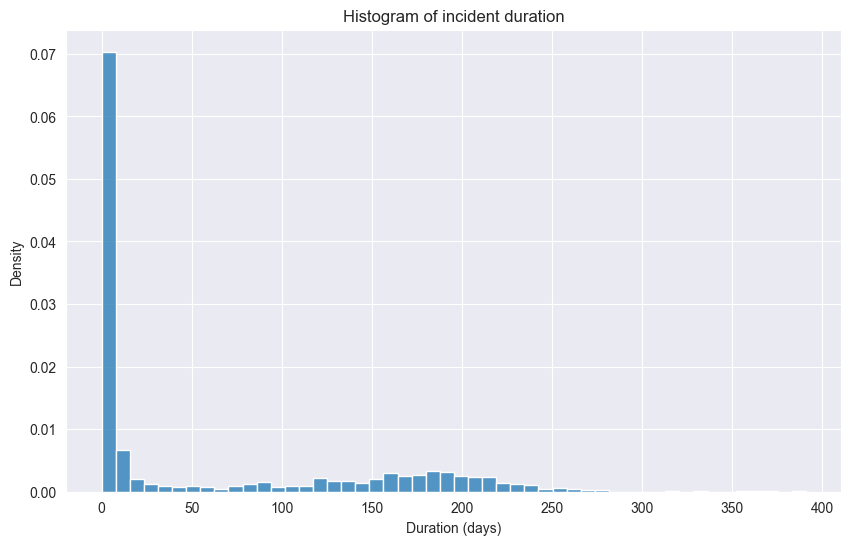

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
df['duration'] = df['incident_date_extinguished'] - df['incident_date_created']
df.loc[df['duration'] < pd.Timedelta(0), 'duration'] = pd.NaT
df['duration_days'] = df['duration'].dt.days

plt.figure(figsize=(10,6))
sns.histplot(df['duration_days'], bins = 50, kde = False, stat = 'density')
plt.title('Histogram of incident duration')
plt.xlabel('Duration (days)')
plt.ylabel('Density')
plt.show()


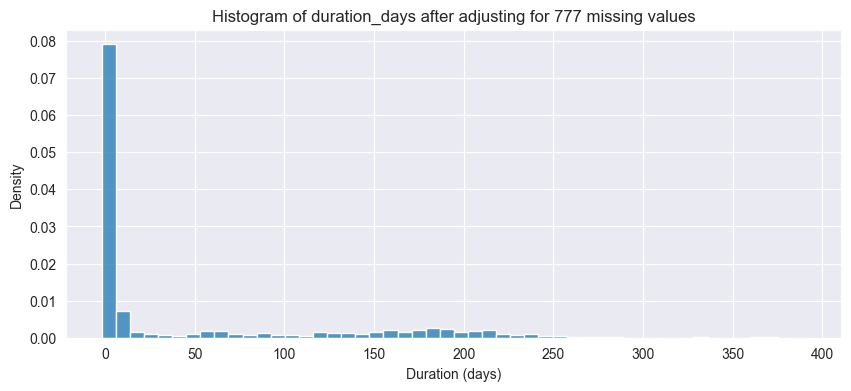

In [8]:
import numpy as np
mean_duration = df['duration_days'].mean()
duration_na_count = df['duration'].isna().sum()


df.loc[df['duration_days'].isna() & (df['incident_acres_burned'] >= 1000), 'duration_days'] = \
    np.random.normal(loc=mean_duration, scale=5, size=(df["duration_days"].isna() & (df["incident_acres_burned"] >= 1000)).sum()).round()
df.loc[df['duration_days'].isna() & (df['incident_acres_burned'] < 1000), 'duration_days'] = \
    np.random.normal(loc=1, scale=1, size=(df["duration_days"].isna() & (df["incident_acres_burned"] < 1000)).sum()).round()

plt.figure(figsize=(10,4))
sns.histplot(df['duration_days'], bins = 50, kde = False, stat = 'density')
plt.title(f'Histogram of duration_days after adjusting for {duration_na_count} missing values')
plt.xlabel('Duration (days)')
plt.ylabel('Density')
plt.show()

In [9]:
df.isnull().sum()

incident_name                       0
incident_date_created               0
incident_administrative_unit       58
incident_county                     0
incident_location                   0
incident_acres_burned               0
incident_containment                0
incident_cooperating_agencies    1506
incident_longitude                  0
incident_latitude                   0
incident_id                         0
incident_url                        0
incident_date_extinguished        703
is_active                           0
calfire_incident                    0
duration                          777
duration_days                       0
dtype: int64

Now that we have completed our data manipulation when it comes to NaN values, we can look at any outliers our data may possess.

### Handling Outliers
With a database such as this that covers such a broad range of attributes (think about how many varying the longitude value could be across the entire state of California), we need to be creative in order to assure that all values are acting accordingly.

The first notion that comes to mind, as just stated, is incident_longitude and incident_latitude. These two values, while quite varying, need to fit into the state of California in order to qualify for our assessment. When putting the data into a geospatial map, it is apparent that some of these latitude, longitude combinations are out of range or null. We can fix this by finding the average of 'incident_longitude' and 'incident_latitude' across the dataset when 'incident_county' is the same as the outlier's. With how many data entries there are in this database, it's unlikely the outliers will have a significant effect on the data when their manipulated like this.

In [10]:
if 'incident_latitude_clean' not in df.columns:
    df['incident_latitude_clean'] = df['incident_latitude']
if 'incident_longitude_clean' not in df.columns:
    df['incident_longitude_clean'] = df['incident_longitude']

def is_outlier(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return True
    return not (32.5 <= lat <= 42 and -124.5 <= lon <= -114)

df['incident_latitude_clean'] = df.apply(
    lambda row: np.nan if is_outlier(row['incident_latitude'], row['incident_longitude'])
    else row['incident_latitude'],
    axis=1
)

df['incident_longitude_clean'] = df.apply(
    lambda row: np.nan if is_outlier(row['incident_latitude'], row['incident_longitude'])
    else row['incident_longitude'],
    axis=1
)

county_means = df.groupby('incident_county')[['incident_longitude_clean', 'incident_latitude_clean']].mean()
df = df.join(county_means, on='incident_county', rsuffix='_county_avg')

df['incident_latitude_clean'] = df['incident_latitude_clean'].fillna(df['incident_latitude_clean_county_avg'])
df['incident_longitude_clean'] = df['incident_longitude_clean'].fillna(df['incident_longitude_clean_county_avg'])
df = df.drop(['incident_latitude_clean_county_avg', 'incident_longitude_clean_county_avg'], axis=1)

print(df[['incident_latitude_clean', 'incident_longitude_clean']].describe())

       incident_latitude_clean  incident_longitude_clean
count              2850.000000               2850.000000
mean                 36.970906               -120.062319
std                   2.501679                  2.003906
min                  32.557566               -124.362017
25%                  34.674907               -121.605040
50%                  37.016427               -120.431842
75%                  38.916695               -118.504892
max                  41.994830               -114.276308


Now we can look towards other important variables, so next lets handle the 'duration' variable that we created earlier. If there are outliers, we will follow the standard data analytics practice of setting the upper limit equal to 1.5 times the interquartile range added to the 75th percentile.

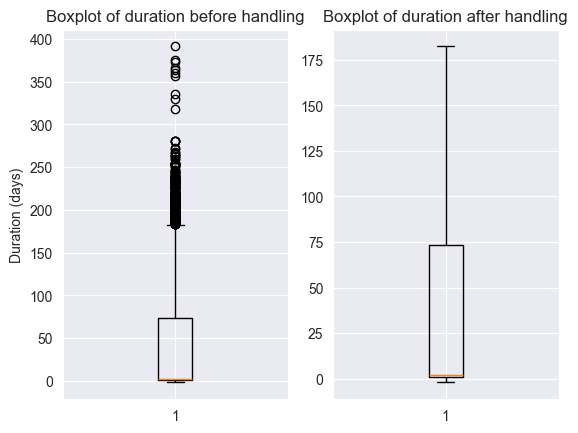

In [14]:
df_original = df.copy()
df_subset = df.copy()

percentile25 = df['duration_days'].quantile(0.25)
percentile75 = df['duration_days'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
df_subset.loc[df_subset['duration_days'] > upper_limit, 'duration_days'] = upper_limit

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)
ax1.boxplot(x=df_original['duration_days'])
ax1.set_title('Boxplot of duration before handling')
ax1.set_ylabel('Duration (days)')

ax2.boxplot(x=df_subset['duration_days'])
ax2.set_title('Boxplot of duration after handling')
plt.show()

In [54]:
#df.loc[df['incident_acres_burned'].isnull(), ['incident_name','incident_county']]
df['incident_county'].value_counts()

incident_county
Riverside          309
Kern               161
Fresno             159
San Diego          149
Los Angeles        113
San Luis Obispo    110
San Bernardino     102
Siskiyou            94
Butte               91
Shasta              82
Tehama              76
Madera              72
Monterey            71
Tulare              71
Lassen              60
Merced              60
Alameda             52
Santa Clara         52
Lake                48
El Dorado           46
Modoc               45
Contra Costa        45
Mariposa            45
Santa Barbara       44
Mendocino           40
San Benito          39
Calaveras           38
Yuba                38
Placer              38
Solano              37
Tuolumne            36
Ventura             33
Humboldt            33
Sacramento          31
Stanislaus          30
Napa                29
Trinity             24
Sonoma              23
San Joaquin         21
Amador              20
Nevada              20
Inyo                17
Kings             

<Axes: xlabel='duration_days'>

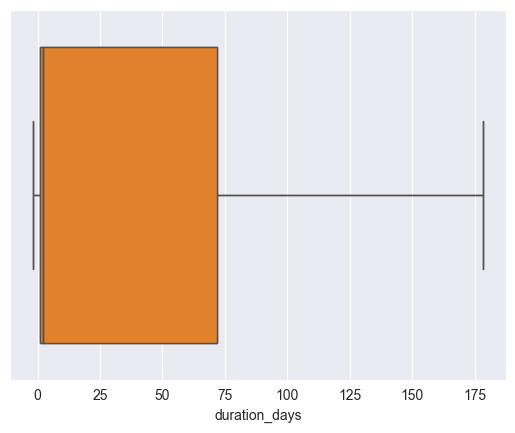

In [21]:
sns.boxplot(x = df['duration_days'])
